In [249]:
import os
import tifffile as tiff
from skimage import measure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#meltpond_1 = data[data["Meltpond_index"] == 6]
#path = os.path.join(os.getcwd(), "Detected_meltponds\\20210706162901_ChristianT\\depths\\7_T27XWM_20210706T162901_gt1ls.tiff")
path= "C:\\Users\\chrel\\Documents\\Fagprojekt_Lokal\\Fagprojekt-Meltponds-master\\Tile_10_07_1609\\T27XWM_20210710T160901_ATL03_20210710155956_02601204_006_01_gt3rw_0.tiff"
img = tiff.imread(path)

#Infrared mask water/Ice mask.
water_mask= img[:,:,3]<2200

min_area = 20

label_img = measure.label(water_mask)
region_props = measure.regionprops(label_img)

label_img_sorted = label_img

for region in region_props:
    # Find the areas that do not fit our criteria and set to 0
    
    if region.area < min_area:
        for cords in region.coords:
            label_img_sorted[cords[0], cords[1]] = 0
#sorted_bin_image is the binary image to take out real pixels
sorted_bin_img = label_img_sorted > 0
            


In [250]:
import rasterio
from rasterio.plot import show,adjust_band

def tiff_to_np_RGB(Sentinel_name):
    """Opens tiff file and converts to np array"""
    with rasterio.open(Sentinel_name) as src:
        # # Convert tiff to np array and transform coordinates
        big_img = np.array([adjust_band(src.read(i)) for i in (3,2,1)])
        gain = 1.5 # Adjust the gain (brightness) of the image
        big_img = big_img * gain
    return big_img,src.transform,src.crs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


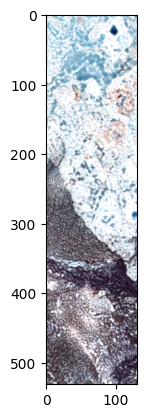

<Axes: >

In [251]:
img_1_RGB=img[:,:,0:3]

img_1_RGB,transform_1,src = tiff_to_np_RGB(path)


show(img_1_RGB)

In [252]:
ponds = np.unique(label_img_sorted)
#take out each pond from tiff image
count = 0
Mean_pixel_ponds=[]
Meltpond_filter=[]
for pond in ponds:
    #create a mask for each pond
    if pond == 0:
        continue
    pond_mask= label_img_sorted == pond
    #reshape mask
    pond_mask =np.reshape(pond_mask,(img_1_RGB.shape[1],img_1_RGB.shape[2]))
    #apply mask to image
    
    pond_img = img[pond_mask]
    #Alle pixels i hver meltpond er nu i pond_img
    #Make a mean of the pixels in the pond
    Pixel_val = pond_img.flatten()
    Pixel_mean = np.mean(Pixel_val)
    Mean_pixel_ponds.append(Pixel_mean)
    
    # meltpond ocean discrimination
    if Pixel_mean > 3800:
        Meltpond_filter.append(pond_mask)
        
    
    
    
    
#den spiller
    
print(Mean_pixel_ponds)
    

[4372.840909090909, 4378.7169811320755, 4570.439655172414, 4282.163043478261, 4592.182692307692, 4622.690476190476, 3320.816964285714, 4517.738571428571, 4475.329787234043, 4382.724358974359, 4406.375, 4355.680609097918, 4077.453703703704, 4308.522727272727, 4440.754901960784, 4243.227380952381, 4547.434782608696, 4337.278571428571, 4333.423913043478, 4336.695652173913, 4331.25, 4144.396428571428, 4276.982142857143, 3958.0, 4266.9078947368425, 4365.184065934066, 4202.3125, 4049.4545454545455, 4123.446428571428, 4089.811111111111, 3819.090909090909, 3588.240484429066, 3940.9154411764707, 4176.714285714285, 3861.2, 3892.5806451612902, 4133.397727272727, 4263.68, 3240.7683978343694, 3925.6, 4041.39, 4228.818181818182, 3802.7276785714284, 4271.615384615385, 3629.978260869565, 3428.30023364486, 3375.7875, 3438.8863636363635, 3486.203703703704, 3468.6370967741937, 3323.98300701884, 3351.7375, 3068.2380589430895]


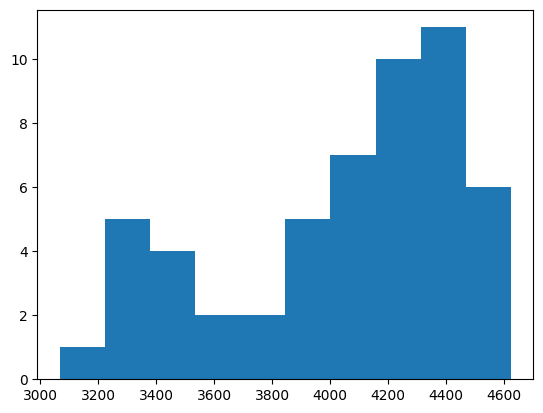

In [253]:
#make a histogram of the mean pixel values 
plt.hist(Mean_pixel_ponds,bins=10)
#show the histogram
plt.show()

[  0   2   3   9  16  21  25  28  37  44  46  57  62  71  78  85  94  95
 101 104 105 106 110 111 123 125 128 145 148 150 172 175 183 193 197 200
 208 223 227 231 232 239 252 263 270 277 330 331 385 405 416 421 444 485]


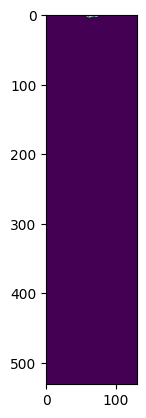

In [254]:
pond_mask= label_img_sorted == 2
plt.imshow(pond_mask)
print(np.unique(label_img_sorted))

(531, 130)
(531, 130)


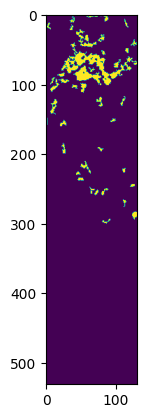

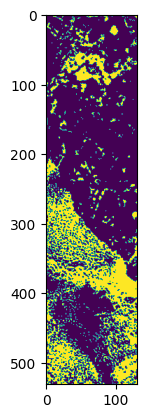

In [255]:

print(label_img.shape)
#combine each pond_mask in Meltpond_filter to one single mask

# Iterate through each pond_mask in Meltpond_filter
combined_mask = np.zeros_like(Meltpond_filter[0])
for pond_mask in Meltpond_filter:
    # Combine the current pond_mask with the combined_mask using a logical OR operation
    combined_mask = np.logical_or(combined_mask, pond_mask)

# If needed, convert the combined_mask back to the same dtype as the original masks
# For example, if the original masks are of dtype 'uint8', convert the combined_mask to 'uint8'
combined_mask = combined_mask.astype(np.uint8)
print(combined_mask.shape)
plt.imshow(combined_mask)
plt.show()
plt.imshow(water_mask)
plt.show()

In [256]:
#Make mask for Meltpond/ocean with mean pond pixel value
